### Ноутбук, побивающий первый бенчмарк.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x1_train = pd.read_csv('train/X1.csv')
y_train = pd.read_csv('train/Y.csv')

x1_test = pd.read_csv('test/X1.csv')

In [3]:
x1_train = x1_train.fillna(x1_train.mean())
x1_test = x1_test.fillna(x1_train.mean())

In [4]:
y_train.describe()

,id,1,2,3,4,5
count,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,4060.31125,0.303750,0.342250,0.328250,0.318500,0.35675
std,2310.14735,0.459933,0.474522,0.469635,0.465953,0.47910
min,3.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2077.75000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4066.00000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,6073.25000,1.000000,1.000000,1.000000,1.000000,1.00000
max,8056.00000,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
for c in y_train.columns[1:]:
    print(c)
    print(y_train[c].value_counts())

1
0    2785
1    1215
Name: 1, dtype: int64
2
0    2631
1    1369
Name: 2, dtype: int64
3
0    2687
1    1313
Name: 3, dtype: int64
4
0    2726
1    1274
Name: 4, dtype: int64
5
0    2573
1    1427
Name: 5, dtype: int64


In [6]:
train = x1_train.join(y_train.set_index('id'), on='id', rsuffix='_target')

Можно заметить, что таргеты коррелируют немного, но в итоге это никак не помогло :(

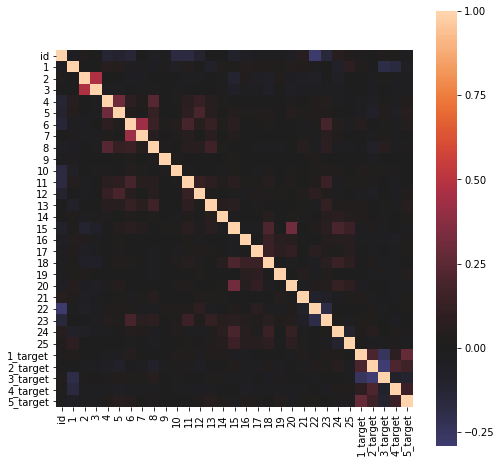

In [7]:
corrmat = train.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corrmat, square=True, center=0)
plt.show()

Не получилось раскрасить графики в цвет значения таргета, поэтому они получились немного бесполезными, но зато красивыми.

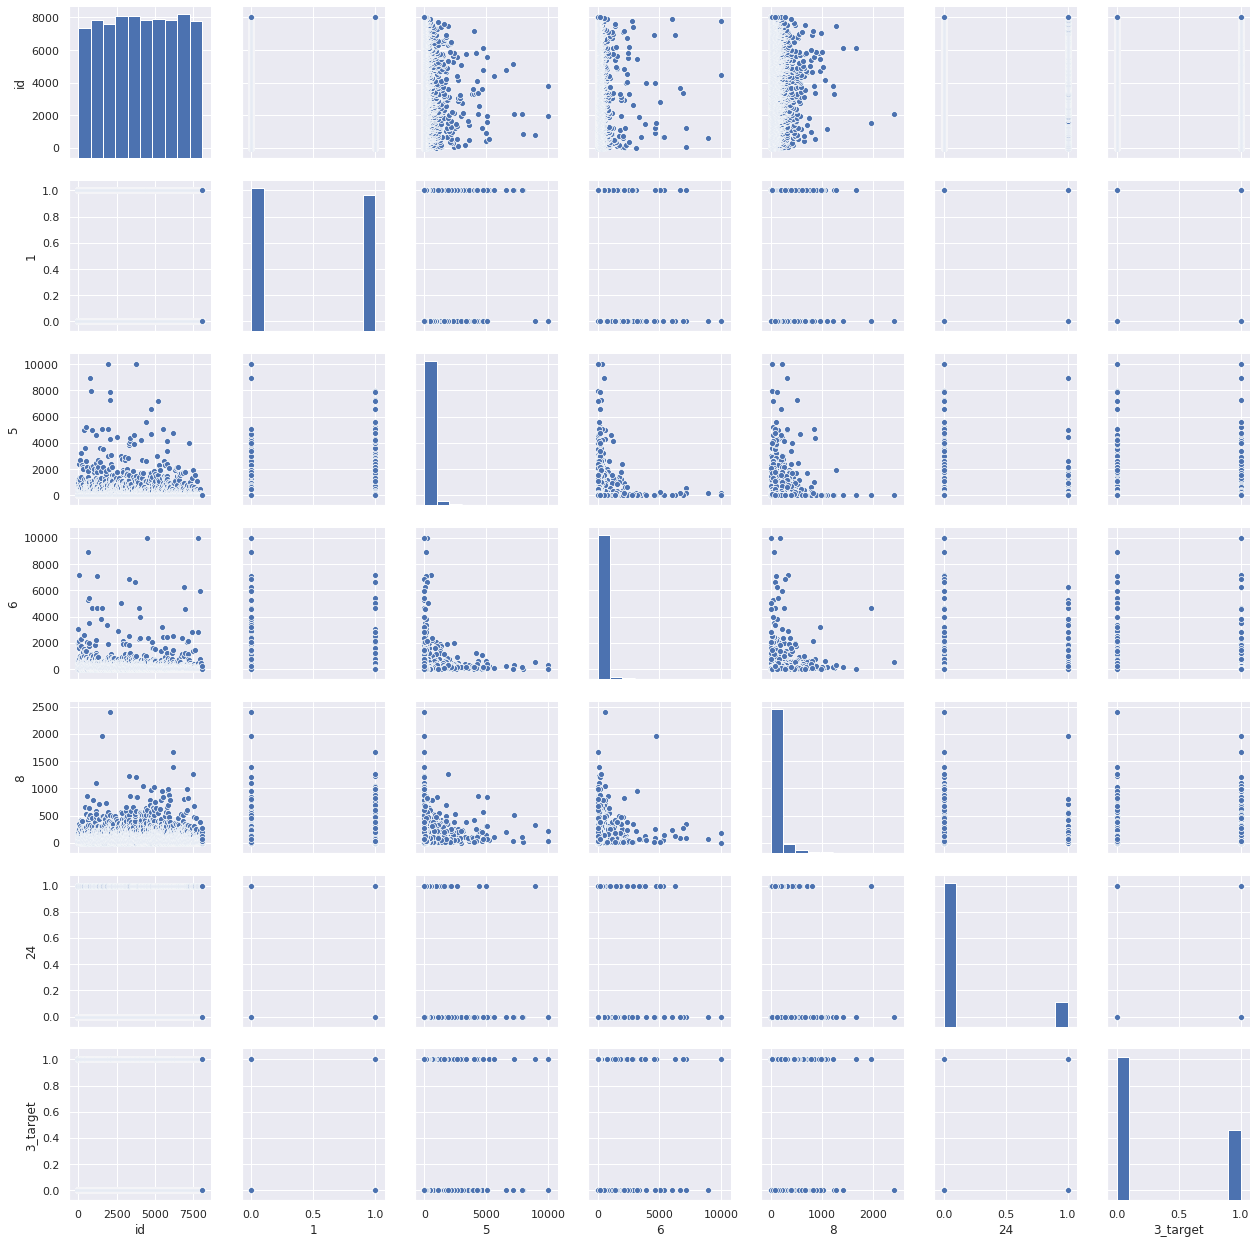

In [34]:
sns.set()
cols = ['id', '1', '5', '6', '8', '24', '3_target']
sns.pairplot(train[cols])

В общем с анализом данных не сложилось, а времени нет, поэтому обучаем RF с перебором параметров в надежде, что бэнчмарк будет побит.

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

In [9]:
train_params_dict = {}
for c in y_train.columns[1:]:
    train_params_dict[f'{c}_target'] = {}

In [10]:
features = train.drop(columns=['id', '1_target', '2_target', '3_target', '4_target', '5_target'])
targets = train[['1_target', '2_target', '3_target', '4_target', '5_target']]
for target_name in train_params_dict:
    for train_val_index, test_index in sss.split(features, targets[[target_name]]):
        continue
    train_params_dict[target_name]['train_val_index'] = train_val_index
    train_params_dict[target_name]['test_index'] = test_index

In [13]:
params = {
    'n_estimators': [5, 8, 10, 15, 20, 40, 50, 60, 80, 100, 120, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5] + [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 3, 4, 5, 8, 10],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
for target_name in train_params_dict:
    rf = RandomForestRegressor(criterion="mse")
    clf = GridSearchCV(rf, params, cv=sss, error_score='raise', scoring='roc_auc', verbose=1)
    train_val_index = train_params_dict[target_name]['train_val_index']
    train_val_data = features.iloc[train_val_index]
    train_val_target = targets[target_name].iloc[train_val_index]
    clf.fit(train_val_data, train_val_target)
    train_params_dict[target_name]['clf'] = clf

Fitting 5 folds for each of 15912 candidates, totalling 79560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 79560 out of 79560 | elapsed: 439.1min finished


Fitting 5 folds for each of 15912 candidates, totalling 79560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [16]:
for target_name in train_params_dict:
    test_index = train_params_dict[target_name]['test_index']
    test_data = features.iloc[test_index]
    test_target = targets[target_name].iloc[test_index]
    prediction = train_params_dict[target_name]['clf'].predict(test_data)
    prediction = np.array(list(map(lambda x: min(max(x, 0), 1), prediction)))
    test_score = roc_auc_score(test_target, prediction)
    train_params_dict[target_name]['test_score'] = test_score

In [17]:
for target_name in train_params_dict:
    print(target_name, train_params_dict[target_name]['test_score'])

1_target 0.6122821405087513
2_target 0.5904047903194471
3_target 0.6334374181305804
4_target 0.5674797625472208
5_target 0.5458695281894055


In [18]:
for target_name in train_params_dict:
    print(train_params_dict[target_name]['clf'].best_params_)

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 60}
{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 60}
{'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 40}
{'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}


In [19]:
x1_test_features = x1_test.drop(columns=['id'])

In [20]:
submission = {'id': x1_test.id}
for i, target_name in enumerate(train_params_dict, 1):
    test_prediction = train_params_dict[target_name]['clf'].predict(x1_test_features)
    test_prediction = np.array(list(map(lambda x: min(max(x, 0), 1), test_prediction)))
    submission[str(i)] = test_prediction

In [21]:
submission_pd = pd.DataFrame(submission)

In [22]:
submission_pd.to_csv('big_gridsearch.csv', index=False)

В итоге этого оказалось достаточно, чтобы побить самый первый бенчмарк.

![sad_pepe](https://i.imgflip.com/22srfb.jpg)